# Streaming machine learning on Arduino

## Setup the environment

In [ ]:
%pip install pyserial
%pip install river

### Loading the datset

In [27]:
from scipy.io import arff
import pandas as pd

data = arff.loadarff('elecNormNew.arff')
df = pd.DataFrame(data[0])
print(df.size)

df.head(20)

def convert(x):
    if x.decode() == 'UP':
        return 1
    else:
        return 0

y_true = list(map(convert,df['class'].values.tolist()))

407808


In [28]:
print(str(df['date'][0]))

def stringBuilder(df,x):
    # Build a string from the data in the dataframe
    string = str(df['nswprice'][x]) + ',' + str(df['nswdemand'][x]) + ',' + str(df['vicprice'][x]) + ',' + str(df['vicdemand'][x]) + ',' + str(df['transfer'][x]) + ',' + str(y_true[x])
    return string
print(stringBuilder(df,0))
print(stringBuilder(df,5))

0.0
0.056443,0.439155,0.003467,0.422915,0.414912,1
0.041161,0.207528,0.003467,0.422915,0.414912,0


## Run

### Start streaming the dataset over serial using the imported dataset

In [29]:
import serial

serialPort = serial.Serial(port="COM10", baudrate=500000, bytesize=8, timeout= None, rtscts=False)

# Configuration
step = 100
featureCount = 5
config = 'partitionDim: ' + str(step) +',featureCount: ' + str(featureCount) +','

res = ""
while 'start sending data' not in res: 
    res = serialPort.readline().decode()
    print(res)
    if 'waiting for configuration msg' in res:
        serialPort.write(config.encode())


# Start sending data
predictions = []
predTime = []
trainTime = []
counter = 0

for partition in range(0, 1000, step):
    data = ""
    for i in range(partition, partition + step):
        data += stringBuilder(df,i) + ',;'
    #print(data)
    serialPort.write(data.encode())

    res = serialPort.readline().decode()
    #print(res)
    samples = res.split(';')
    for x in range(0,len(samples)-1):
        sample = samples[x]
        for out in sample.split(','):
            if 'predicted:' in out:
                predict = int(out.split(':')[1])
                #print(predict)
                predictions.append(predict)   
                if (predict == y_true[partition+x]):
                    counter += 1
            if 'prediction_time:' in out:
                predTime.append(int(out.split(':')[1]))
            if 'train_time:' in out:
                trainTime.append(int(out.split(':')[1]))


    print('accuracy after '+ str(partition+step) + ': '+ "{:.3f}".format(counter/(partition+step)), end='')
    #print(', avg pred time: ' + str(int(sum(predTime)/len(predTime))) + 'μs, avg train time: ' + str(int(sum(trainTime)/len(trainTime))) + 'μs')
    print()
print('accuracy: ' + str(counter/len(predictions)))
serial.Serial.close(serialPort)


Serial started

waiting for configuration msg

configuration msg received

partitionDim: 100, featureCount: 5

start sending data

accuracy after 100: 0.770
accuracy after 200: 0.785
accuracy after 300: 0.727
accuracy after 400: 0.740
accuracy after 500: 0.686
accuracy after 600: 0.688
accuracy after 700: 0.683
accuracy after 800: 0.704
accuracy after 900: 0.700
accuracy after 1000: 0.710
accuracy: 0.71


### Start streaming the dataset over serial using the Sine dataset

In [23]:
import serial
from river.datasets import synth
dataset = synth.Sine(classification_function = 2, seed = 112,balance_classes = True, has_noise = False)
def stringBuilderSine(instance):
    return str(instance[0][0]) + ',' + str(instance[0][1]) + ',' + str(instance[1])

serialPort = serial.Serial(port="COM10", baudrate=500000, bytesize=8, timeout= None, rtscts=False)

# Configuration
step = 50
featureCount = 2
config = 'partitionDim: ' + str(step) +',featureCount: ' + str(featureCount) +','

res = ""
while 'start sending data' not in res: 
    res = serialPort.readline().decode()
    print(res)
    if 'waiting for configuration msg' in res:
        serialPort.write(config.encode())


# Start sending data
y_true = []
predictions = []
predTime = []
trainTime = []
counter = 0
try:
    for partition in range(0, 1300, step):
        data = ""
        for instance in dataset.take(step):
            y_true.append(instance[1])
            data += stringBuilderSine(instance) + ',;'
        #print(data)
        serialPort.write(data.encode())

        res = serialPort.readline().decode()
        #print(res)
        samples = res.split(';')
        for x in range(0,len(samples)-1):
            sample = samples[x]
            for out in sample.split(','):
                if 'predicted:' in out:
                    predict = int(out.split(':')[1])
                    #print(predict)
                    predictions.append(predict)   
                    if (predict == y_true[partition+x]):
                        counter += 1
                if 'prediction_time:' in out:
                    predTime.append(int(out.split(':')[1]))
                if 'train_time:' in out:
                    trainTime.append(int(out.split(':')[1]))


        print('accuracy after '+ str(partition+step) + ': '+ "{:.3f}".format(counter/(partition+step)), end='')
        #print(', avg pred time: ' + str(int(sum(predTime)/len(predTime))) + 'μs, avg train time: ' + str(int(sum(trainTime)/len(trainTime))) + 'μs')
        print()
    print('accuracy: ' + str(counter/len(predictions)))
    #serial.Serial.close(serialPort)
except: 
    serial.Serial.close(serialPort)
finally:
    serial.Serial.close(serialPort)


Serial started

waiting for configuration msg

configuration msg received

partitionDim: 50, featureCount: 2

start sending data

accuracy after 50: 0.980
accuracy after 100: 0.990
accuracy after 150: 0.993
accuracy after 200: 0.995
accuracy after 250: 0.996
accuracy after 300: 0.997
accuracy after 350: 0.997
accuracy after 400: 0.998
accuracy after 450: 0.998
accuracy after 500: 0.998
accuracy after 550: 0.998
accuracy after 600: 0.998
accuracy after 650: 0.998
accuracy after 700: 0.999
accuracy after 750: 0.999
accuracy after 800: 0.999
accuracy after 850: 0.999
accuracy after 900: 0.999
accuracy after 950: 0.999
accuracy after 1000: 0.999
accuracy after 1050: 0.999
accuracy after 1100: 0.999
accuracy after 1150: 0.999
accuracy after 1200: 0.999
accuracy after 1250: 0.999
accuracy after 1300: 0.982
accuracy: 0.9823076923076923


### Analize the results

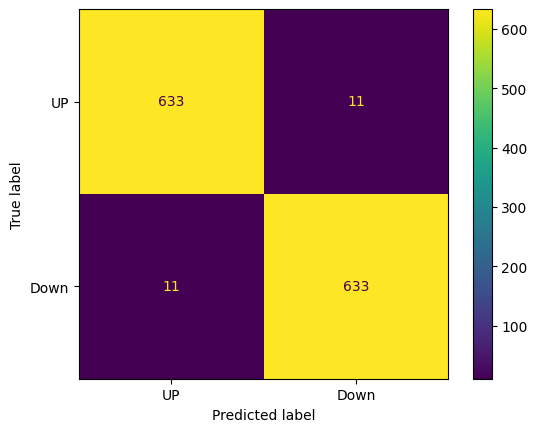

              precision    recall  f1-score   support

          UP       0.98      0.98      0.98       644
        Down       0.98      0.98      0.98       644

    accuracy                           0.98      1288
   macro avg       0.98      0.98      0.98      1288
weighted avg       0.98      0.98      0.98      1288

accuracy after 1300: 0.982, avg pred time: 34μs, avg train time: 23282μs



In [24]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn import metrics

start = 12
end = len(predictions)

yy_true = y_true[start:end]
y_pred = predictions[start:end]
#print(df['class'].values.tolist()[start:end])
#print(yy_true)
#print(predictions)
confusion_matrix = confusion_matrix(yy_true, y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['UP', 'Down'])

cm_display.plot()
plt.show()
print(metrics.classification_report(yy_true, y_pred, target_names = ['UP', 'Down']))
print('accuracy after '+ str(partition+step) + ': '+ "{:.3f}".format(counter/(partition+step)), end='')
print(', avg pred time: ' + str(int(sum(predTime)/len(predTime))) + 'μs, avg train time: ' + str(int(sum(trainTime)/len(trainTime))) + 'μs')
print()